In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('Data/dataset-case-iqvia.csv', sep=',')
df['week_dt'] = pd.to_datetime(df['week_dt'])

---

# EDA

In [3]:
df_total = df.groupby('week_dt')['units_qty'].sum().reset_index()
df_total = df_total.sort_values('week_dt')
df_total.set_index('week_dt', inplace=True)

<Axes: xlabel='week_dt'>

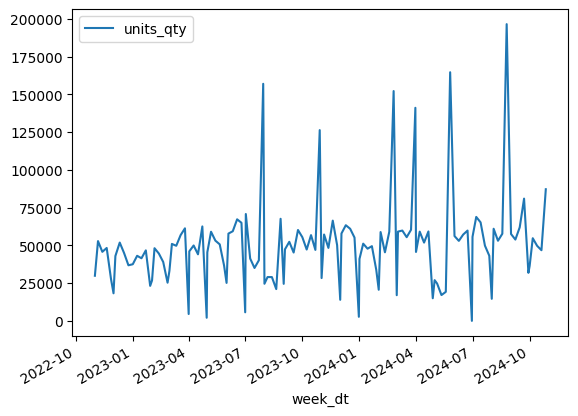

In [4]:
df_total.plot()

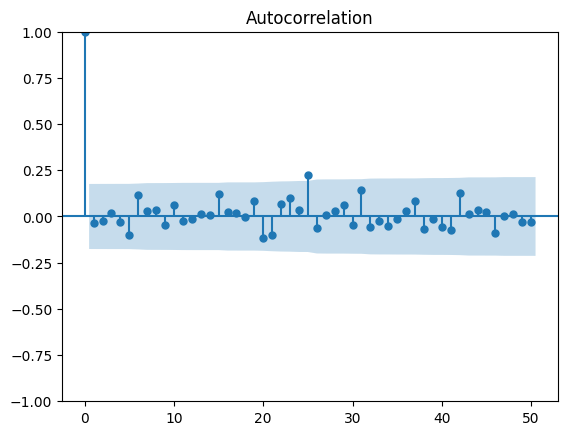

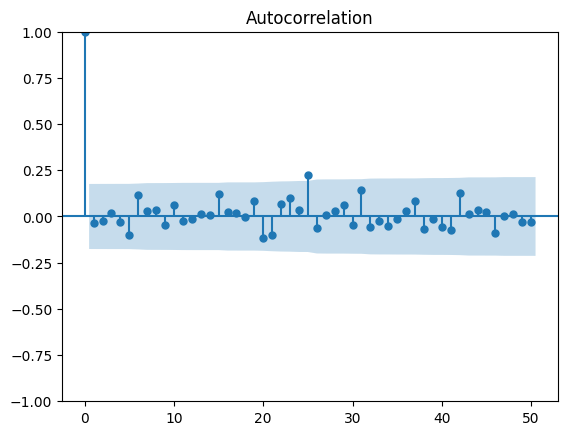

In [5]:
plot_acf(df_total['units_qty'], lags=50)

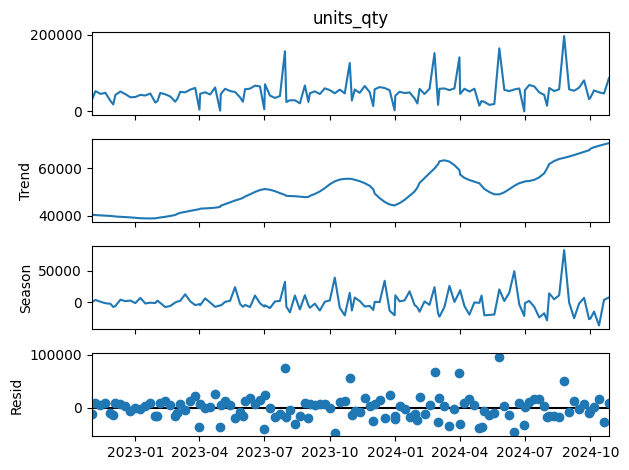

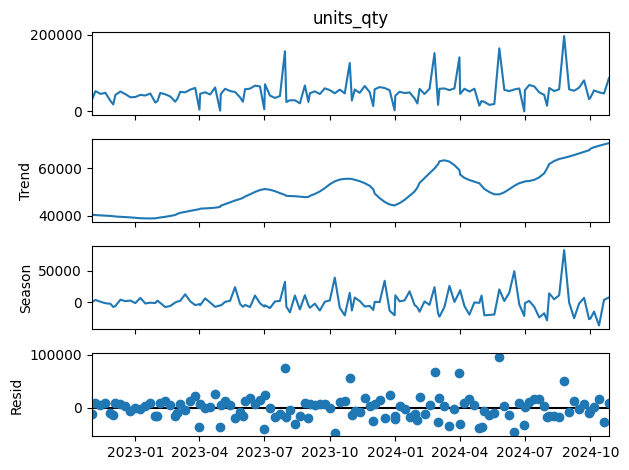

In [6]:
stl = STL(df_total['units_qty'], period=12)
res = stl.fit()
res.plot()

---

# Sarimax - Fornecimento Total

In [7]:
df_total.describe()

,units_qty
count,124.000000
mean,50297.489669
std,29652.901711
min,39.000000
25%,36109.410000
50%,49632.780000
75%,58912.620000
max,196569.800000


In [8]:
for lag in [1, 2, 3, 4, 5, 6, 12]:
    df_total[f'lag_{lag}'] = df_total['units_qty'].shift(lag)

df_total['rolling_mean_3'] = df_total['units_qty'].shift(1).rolling(window=3).mean()
df_total['rolling_mean_6'] = df_total['units_qty'].shift(1).rolling(window=6).mean()
df_total['rolling_std_3'] = df_total['units_qty'].shift(1).rolling(window=3).std()
df_total['rolling_std_6'] = df_total['units_qty'].shift(1).rolling(window=6).std()

df_total.dropna(inplace=True)

In [9]:
y = df_total['units_qty']
exog = df_total[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3', 'rolling_std_6']]

model = SARIMAX(y, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,25))
pred = model.fit()

pred.summary()

H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          units_qty   No. Observations:                  112
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 25)   Log Likelihood               -1023.291
Date:                            Fri, 02 May 2025   AIC                           2078.582
Time:                                    12:58:06   BIC                           2117.852
Sample:                                         0   HQIC                          2094.386
                                            - 112                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
lag_1             -0.3507      0.428     -0.819      0.413      -1.190       0.489
lag_2             -0.1854      0.423     -0.438      0.661      -1.014       0.644
lag_3             -0.0607      0.361     -0.168      0.866      -0.768       0.646
lag_4             -0.0760      0.392     -0.194      0.846      -0.844       0.692
lag_5             -0.1220      0.278     -0.439      0.660      -0.666       0.422
lag_6             -0.0477      0.255     -0.187      0.852      -0.548       0.452
lag_12            -0.0193      0.241     -0.080      0.936      -0.492       0.453
rolling_mean_3    -0.1979      0.370     -0.535      0.593      -0.923       0.527
rolling_mean_6    -0.1392      0.272     -0.513      0.608      -0.672       0.393
rolling_std_3     -0.2096      0.487     -0.430      0.667      -1.164       0.745
rolling_std_6     -0.4089      1.194     -0.343      0.732      -2.748       1.931
ar.L1              0.4937      0.671      0.735      0.462      -0.822       1.810
ma.L1             -0.8851      0.211     -4.187      0.000      -1.300      -0.471
ar.S.L25           0.0237      0.390      0.061      0.952      -0.741       0.789
ma.S.L25          -0.6157      0.475     -1.295      0.195      -1.548       0.316
sigma2          1.665e+09   1.32e-09   1.26e+18      0.000    1.66e+09    1.66e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                27.57
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.91
Prob(H) (two-sided):                  0.35   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.45e+33. Standard errors may be unstable.
"""

In [10]:
df_total['forecast'] = pred.predict(start=0, end=len(df_total)-1, exog=exog)

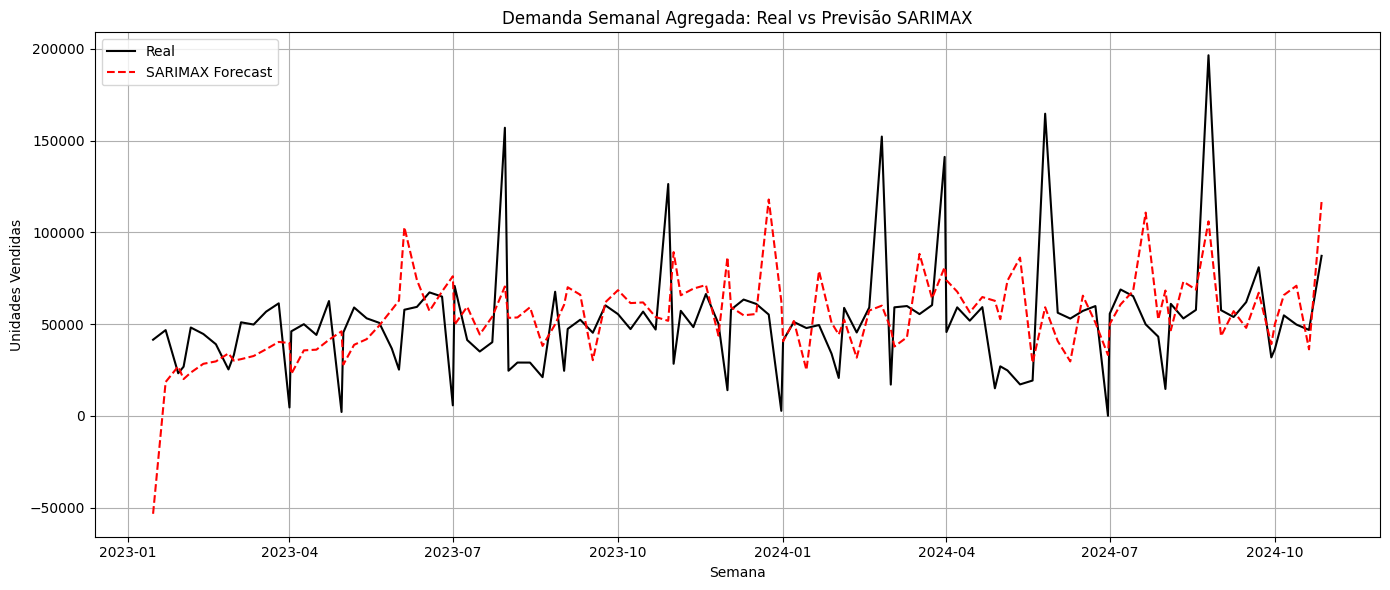

In [11]:
plt.figure(figsize=(14,6))
plt.plot(df_total.index, df_total['units_qty'], label='Real', color='black')
plt.plot(df_total.index, df_total['forecast'], label='SARIMAX Forecast', color='red', linestyle='--')
plt.title('Demanda Semanal Agregada: Real vs Previsão SARIMAX')
plt.xlabel('Semana')
plt.ylabel('Unidades Vendidas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Sarimax - Região e Distribuidor

In [12]:
df_grouped = df.groupby(['week_dt', 'dsupp_id', 'region_nm'])['units_qty'].sum().reset_index()

In [35]:
def sarimax_group(dsupp_id, region_nm):
    df_filtrado = df_grouped[
        (df_grouped['dsupp_id'] == dsupp_id) &
        (df_grouped['region_nm'] == region_nm)
    ].copy()

    
    df_filtrado = df_filtrado.sort_values('week_dt')
    
    df_filtrado.set_index('week_dt', inplace=True)

    for lag in [1, 2, 3, 4, 5, 6, 12]:
        df_filtrado[f'lag_{lag}'] = df_filtrado['units_qty'].shift(lag)
    
    df_filtrado['rolling_mean_3'] = df_filtrado['units_qty'].shift(1).rolling(window=3).mean()
    df_filtrado['rolling_mean_6'] = df_filtrado['units_qty'].shift(1).rolling(window=6).mean()
    df_filtrado['rolling_std_3'] = df_filtrado['units_qty'].shift(1).rolling(window=3).std()
    df_filtrado['rolling_std_6'] = df_filtrado['units_qty'].shift(1).rolling(window=6).std()
    
    df_filtrado.dropna(inplace=True)

    y = df_filtrado['units_qty']
    exog = df_filtrado[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6', 'rolling_std_3', 'rolling_std_6']]

    model = SARIMAX(y, exog=exog, order=(1,1,1), seasonal_order=(1,1,1,25))
    pred = model.fit()

    df_filtrado['forecast'] = pred.predict(start=0, end=len(df_filtrado)-1, exog=exog)

    plt.figure(figsize=(14,5))
    plt.plot(df_filtrado.index, df_filtrado['units_qty'], label='Real', color='black')
    plt.plot(df_filtrado.index, df_filtrado['forecast'], label='Previsão', color='red', linestyle='--')
    plt.title(f'Demanda Real vs. Prevista - Distribuidor {dsupp_id} | Região {region_nm}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pred

H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
H:\Users\Henry\anaconda3\envs\huggingface\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed

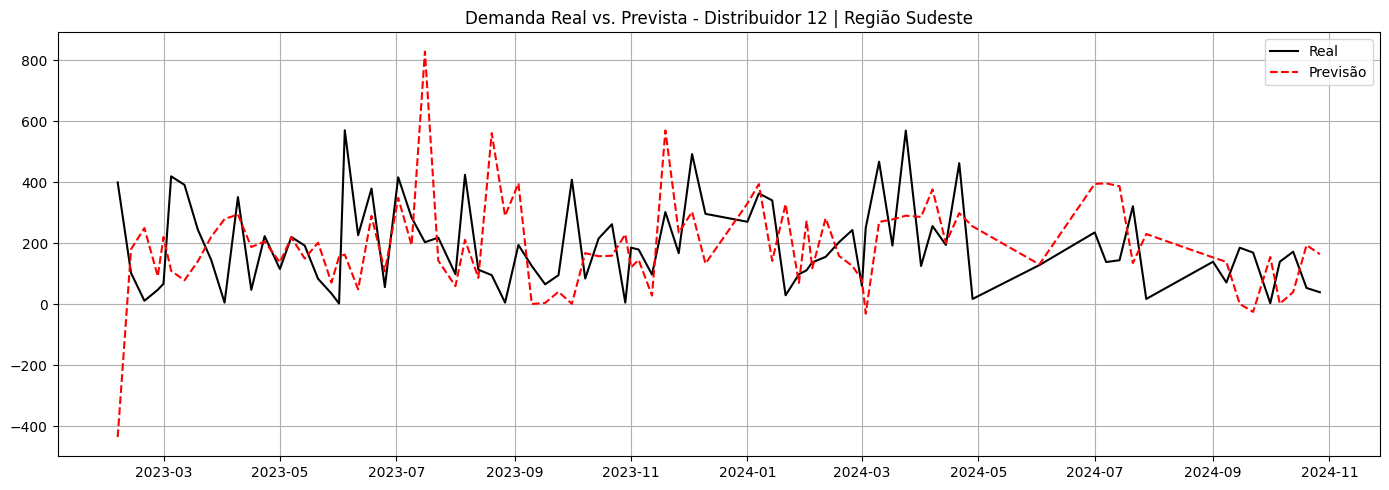

In [36]:
model = sarimax_group(12, 'Sudeste')